In [1]:
!pip install pennylane-qchem

In [0]:
import numpy as np
import pennylane as qml
from pennylane import expval, var, device

In [3]:
name ='BeH2';charge = 0; multiplicity=1; basis= 'sto-3g'; geometry = 'beh2.xyz';
h, nr_qubits = qml.qchem.generate_hamiltonian(
    name,
    geometry,
    charge,
    multiplicity,
    basis,
    mapping='jordan_wigner',
    n_active_orbitals=3,
    n_active_electrons=2,
)
print(h, '\n', nr_qubits)

(-13.763658581986853) [I0]
+ (-0.02049157680747858) [Z0]
+ (-9.106018753618769e-07) [Y0 Z1 Y2]
+ (-9.106018753618769e-07) [X0 Z1 X2]
+ (-0.020491576807478568) [Z1]
+ (-9.106018753618776e-07) [Y1 Z2 Y3]
+ (-9.106018753618776e-07) [X1 Z2 X3]
+ (-0.1618152952732591) [Z2]
+ (-0.16181529527325908) [Z3]
+ (-0.1731301301411197) [Z4]
+ (-0.17313013014111972) [Z5]
+ (0.13215881120497855) [Z0 Z1]
+ (-1.4048789458790822e-06) [Y0 Y2]
+ (-1.4048789458790822e-06) [X0 X2]
+ (-1.4048789458790822e-06) [Z0 Y1 Z2 Y3]
+ (-1.4048789458790822e-06) [Z0 X1 Z2 X3]
+ (0.005697940665217693) [Y0 X1 X2 Y3]
+ (-0.005697940665217693) [Y0 Y1 X2 X3]
+ (-0.005697940665217693) [X0 X1 Y2 Y3]
+ (0.005697940665217693) [X0 Y1 Y2 X3]
+ (0.005288945284752739) [Y0 X1 X4 Y5]
+ (-0.005288945284752739) [Y0 Y1 X4 X5]
+ (-0.005288945284752739) [X0 X1 Y4 Y5]
+ (0.005288945284752739) [X0 Y1 Y4 X5]
+ (0.09482086680073133) [Z0 Z2]
+ (0.10051880746594904) [Z0 Z3]
+ (8.803099615617148e-07) [Y0 Z1 Y2 Z3]
+ (8.803099615617148e-07) [X0 Z1 X

In [0]:
dev = qml.device("default.qubit", wires=6)

def circuit(params, wires=[0,1,2,3,4,5]):
    for i in wires:
        qml.RY(params[i], wires=wires[i])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.CNOT(wires=[wires[4], wires[5]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[3], wires[4]])
    for i in wires:
        qml.RY(params[i+6], wires=wires[i])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.CNOT(wires=[wires[4], wires[5]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[3], wires[4]])

In [0]:
qnodes = qml.map(circuit, h.ops, dev, measure='expval')
expval = qml.dot([h.coeffs], qnodes)

In [0]:
step_size = 0.5
max_iterations = 400
conv_tol = 1e-06

print_freq = 20

initial_params = np.random.uniform(low=0, high=2*np.pi, size=12)

In [10]:
params = initial_params
prev_energy = expval(params)
qng_energies_block = []

for n in range(max_iterations):
    
    grad_cost = qml.grad(expval, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(
                np.linalg.pinv(qnodes[0].metric_tensor([params])), 
                grad_at_point)

    energy = expval(params)
    qng_energies_block.append(energy)
    
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = ', n, 'Energy =', energy, 'Ha', 'Convergence parameter =', conv, 'Ha')

    if conv <= conv_tol:
        qng_block_steps = n
        break

    prev_energy = energy

print()
print('Number of iterations = ', qng_block_steps)

Iteration =  0 Energy = [-13.8783902] Ha Convergence parameter = [0.12462163] Ha
Iteration =  20 Energy = [-14.30085349] Ha Convergence parameter = [0.00320106] Ha
Iteration =  40 Energy = [-14.42940571] Ha Convergence parameter = [0.003607] Ha
Iteration =  60 Energy = [-14.44315646] Ha Convergence parameter = [2.48881962e-05] Ha

Number of iterations =  73


In [11]:
params = initial_params
prev_energy = expval(params)
qng_energies_diag = []

for n in range(max_iterations):
    
    grad_cost = qml.grad(expval, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(np.linalg.pinv(qnodes[0].metric_tensor([params], diag_approx=True)),
                                         grad_at_point)

    energy = expval(params)
    qng_energies_diag.append(energy)
    
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = ', n, 'Energy =', energy, 'Ha', 'Convergence parameter =', conv, 'Ha')

    if conv <= conv_tol:
        qng_diag_steps = n
        break

    prev_energy = energy

print()
print('Number of iterations = ', qng_diag_steps)

Iteration =  0 Energy = [-13.87983933] Ha Convergence parameter = [0.12607075] Ha
Iteration =  20 Energy = [-14.31826493] Ha Convergence parameter = [0.00587662] Ha
Iteration =  40 Energy = [-14.44049305] Ha Convergence parameter = [0.00086126] Ha
Iteration =  60 Energy = [-14.44322458] Ha Convergence parameter = [4.03084763e-06] Ha

Number of iterations =  67


In [12]:
params = initial_params
prev_energy = expval(params)
vanilla_energies = []

for n in range(max_iterations):
    
    grad_cost = qml.grad(expval, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(step_size, grad_at_point)

    energy = expval(params)
    vanilla_energies.append(energy)
    
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = ', n, 'Energy =', energy, 'Ha', 'Convergence parameter =', conv, 'Ha')

    if conv <= conv_tol:
        break

    prev_energy = energy

print()
print('Number of iterations = ', n)

Iteration =  0 Energy = [-13.77141755] Ha Convergence parameter = [0.01764898] Ha
Iteration =  20 Energy = [-14.05754958] Ha Convergence parameter = [0.01086086] Ha
Iteration =  40 Energy = [-14.17790466] Ha Convergence parameter = [0.00311497] Ha
Iteration =  60 Energy = [-14.22015892] Ha Convergence parameter = [0.00164251] Ha
Iteration =  80 Energy = [-14.24905298] Ha Convergence parameter = [0.00127829] Ha
Iteration =  100 Energy = [-14.27066055] Ha Convergence parameter = [0.00090516] Ha
Iteration =  120 Energy = [-14.28568894] Ha Convergence parameter = [0.00063751] Ha
Iteration =  140 Energy = [-14.29707109] Ha Convergence parameter = [0.00053299] Ha
Iteration =  160 Energy = [-14.30810057] Ha Convergence parameter = [0.00059611] Ha
Iteration =  180 Energy = [-14.32227985] Ha Convergence parameter = [0.00083753] Ha
Iteration =  200 Energy = [-14.34247089] Ha Convergence parameter = [0.00115832] Ha
Iteration =  220 Energy = [-14.36754113] Ha Convergence parameter = [0.00129271] H

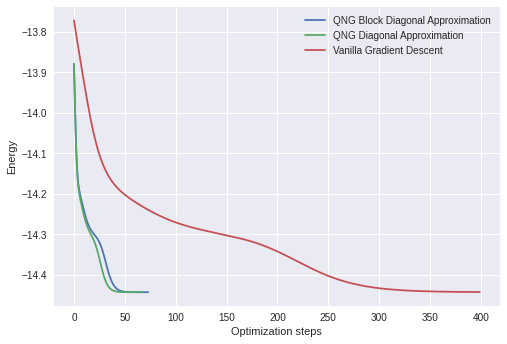

In [13]:
from matplotlib import pyplot as plt

plt.style.use("seaborn")
plt.plot(qng_energies_block, label="QNG Block Diagonal Approximation")
plt.plot(qng_energies_diag, label="QNG Diagonal Approximation")
plt.plot(vanilla_energies, label="Vanilla Gradient Descent")

plt.ylabel("Energy")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()